#Instalar librerias

In [1]:
!pip install pandas numpy networkx matplotlib scikit-learn torch torch-geometric osmnx geopandas contextily shapely


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 88.1 MB/s eta 0:00:00


# import y setup inicial

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx

plt.rcParams["figure.figsize"] = (8, 8)


# dataset

In [3]:
ruta_csv = "/content/Siniestros_urbanos_Metropolitana_2024.csv"
df = pd.read_csv(ruta_csv)

df.head()

X             Y  FID   Año  IdAccident    Latitud   longitud  \
0 -7.862396e+06 -3.955511e+06    1  2024     1587058 -33.452426 -70.629108   
1 -7.859285e+06 -3.955788e+06    2  2024     1587059 -33.454502 -70.601157   
2 -7.927226e+06 -3.987380e+06    3  2024     1587079 -33.690955 -71.211487   
3 -7.929043e+06 -3.987076e+06    4  2024     1587081 -33.688686 -71.227804   
4 -7.872821e+06 -3.960612e+06    5  2024     1587085 -33.490650 -70.722755   

   ClaseAccid                   Fecha                    Hora  ... Ubicaci_1  \
0           1  2024/01/26 00:00:00+00  1899/12/30 00:00:00+00  ...             
1           1  2024/01/23 00:00:00+00  1899/12/30 00:00:00+00  ...             
2           1  2024/01/16 00:00:00+00  1899/12/30 00:00:00+00  ...             
3           1  2024/01/16 00:00:00+00  1899/12/30 00:00:00+00  ...             
4           1  2024/01/27 00:00:00+00  1899/12/30 00:00:00+00  ...             

                      Calzada Tipo_Calza Estado_Cal Condición Estado_Atm  \
0  BIDIRECCIONAL CON BANDEJON   CONCRETO      BUENO      SECO  DESPEJADO   
1  BIDIRECCIONAL CON BANDEJON   CONCRETO      BUENO      SECO  DESPEJADO   
2              UNIDIRECCIONAL    ASFALTO      BUENO      SECO  DESPEJADO   
3              UNIDIRECCIONAL    ASFALTO      BUENO      SECO  DESPEJADO   
4               BIDIRECCIONAL    ASFALTO      BUENO      SECO  DESPEJADO   

  Fallecidos Graves Menos_Grav Leves  
0          0      0          0     0  
1          0      0          0     1  
2          0      0          0     0  
3          0      0          0     3  
4          0      0          0     0  

[5 rows x 33 columns]

# limpieza de dataset

In [4]:
# solo filas sin nan
df = df.dropna(subset=["Latitud", "longitud"])

# nos aseguramos que estas columnas existan
for col in ["Fallecidos", "Graves", "Menos_Grav", "Leves"]:
    if col not in df.columns:
        raise ValueError(f"Falta la columna '{col}' en el CSV.")

#convertimos a numérico por si acaso
for col in ["Fallecidos", "Graves", "Menos_Grav", "Leves"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

df[["Latitud", "longitud", "Fallecidos", "Graves", "Menos_Grav", "Leves"]].head()


Latitud   longitud  Fallecidos  Graves  Menos_Grav  Leves
0 -33.452426 -70.629108           0       0           0      0
1 -33.454502 -70.601157           0       0           0      1
2 -33.690955 -71.211487           0       0           0      0
3 -33.688686 -71.227804           0       0           0      3
4 -33.490650 -70.722755           0       0           0      0

# grafo red vial

In [5]:
lugar = "Región Metropolitana de Santiago, Chile"
G = ox.graph_from_place(lugar, network_type="drive")
print(G)


MultiDiGraph with 154438 nodes and 375980 edges


# mapeamos cada accidente al nodo más cercano

In [6]:
df["osm_node"] = ox.nearest_nodes(
    G,
    X=df["longitud"].values,
    Y=df["Latitud"].values
)

df[["Latitud", "longitud", "osm_node"]].head()

Latitud   longitud     osm_node
0 -33.452426 -70.629108     15092684
1 -33.454502 -70.601157    255473300
2 -33.690955 -71.211487    889424866
3 -33.688686 -71.227804   1023759760
4 -33.490650 -70.722755  12558986943

# accidentes por nodo

In [7]:
agg = (
    df.groupby("osm_node")
      .agg(
          accidentes_totales=("FID", "count"),
          fallecidos=("Fallecidos", "sum"),
          graves=("Graves", "sum"),
          menos_grav=("Menos_Grav", "sum"),
          leves=("Leves", "sum"),
      )
      .reset_index()
)

agg.head(), agg.describe()

(   osm_node  accidentes_totales  fallecidos  graves  menos_grav  leves
 0    386138                   8           0       1           0      3
 1    386139                   4           1       0           0      0
 2    386140                   1           0       1           0      0
 3    386157                   2           0       0           0      0
 4    386184                  10           0       0           0      4,
            osm_node  accidentes_totales   fallecidos       graves  \
 count  9.743000e+03         9743.000000  9743.000000  9743.000000   
 mean   1.909085e+09            2.076670     0.023504     0.142872   
 std    2.804492e+09            3.524203     0.170625     0.452090   
 min    3.861380e+05            1.000000     0.000000     0.000000   
 25%    2.690344e+08            1.000000     0.000000     0.000000   
 50%    5.046094e+08            1.000000     0.000000     0.000000   
 75%    2.104815e+09            2.000000     0.000000     0.000000   
 max   

# calcular features estructurales
Vamos a usar solo features de la red vial (no las de accidentes) como entrada al modelo, para que el problema tenga sentido

In [10]:
G_simple = nx.Graph(G)  # colapsa aristas múltiples entre los mismos nodos
clustering_dict = nx.clustering(G_simple)
node_list = list(G_simple.nodes)
node_to_idx = {n: i for i, n in enumerate(node_list)}

# Diccionario con accidentes agregados por nodo (target)
acc_dict = agg.set_index("osm_node")["accidentes_totales"].to_dict()

degrees = []
clusterings = []
street_counts = []
targets = []

for n in node_list:
    deg = G_simple.degree(n)
    degrees.append(deg)

    # clustering
    clust = clustering_dict.get(n, 0.0)
    clusterings.append(clust)

    # street_count viene del grafo original G
    street_count = G.nodes[n].get("street_count", deg)
    street_counts.append(street_count)

    # target: accidentes totales
    targets.append(float(acc_dict.get(n, 0.0)))

features = np.vstack([degrees, clusterings, street_counts]).T
features.shape, len(targets)


((154438, 3), 154438)

# construimos edge_index y data

In [11]:
edges = []
for u, v in G.edges():
    iu = node_to_idx[u]
    iv = node_to_idx[v]
    edges.append((iu, iv))
    edges.append((iv, iu))

edge_index = np.array(edges, dtype=np.int64).T

x = torch.tensor(features, dtype=torch.float32)
y = torch.tensor(targets, dtype=torch.float32)

data = Data(
    x=x,
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    y=y
)

data


Data(x=[154438, 3], edge_index=[2, 751960], y=[154438])

# Split

In [12]:
num_nodes = data.num_nodes
indices = np.arange(num_nodes)
np.random.shuffle(indices)

train_size = int(0.8 * num_nodes)
train_idx = torch.tensor(indices[:train_size], dtype=torch.long)
test_idx  = torch.tensor(indices[train_size:], dtype=torch.long)

len(train_idx), len(test_idx)


(123550, 30888)

# GCN con regresión

In [13]:
#GCN para regresión

class GCNReg(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x.view(-1)  # vector [num_nodes]

model = GCNReg(
    in_channels=data.x.shape[1],
    hidden_channels=32
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.MSELoss()


# entrenamiento y evaluar

In [14]:
def evaluar_regresion(model, data, idx):
    model.eval()
    with torch.no_grad():
        pred = model(data)[idx]
        true = data.y[idx]
        mse  = mean_squared_error(true.cpu().numpy(), pred.cpu().numpy())
        mae  = mean_absolute_error(true.cpu().numpy(), pred.cpu().numpy())
    return mse, mae

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_mse, train_mae = evaluar_regresion(model, data, train_idx)
        test_mse, test_mae   = evaluar_regresion(model, data, test_idx)
        print(
            f"Epoch {epoch:3d} | "
            f"Loss {loss.item():.4f} | "
            f"Train RMSE {np.sqrt(train_mse):.3f} | Test RMSE {np.sqrt(test_mse):.3f} | "
            f"Test MAE {test_mae:.3f}"
        )


Epoch  20 | Loss 1.1637 | Train RMSE 1.080 | Test RMSE 0.722 | Test MAE 0.298
Epoch  40 | Loss 1.1590 | Train RMSE 1.077 | Test RMSE 0.715 | Test MAE 0.239
Epoch  60 | Loss 1.1571 | Train RMSE 1.076 | Test RMSE 0.714 | Test MAE 0.231
Epoch  80 | Loss 1.1547 | Train RMSE 1.075 | Test RMSE 0.714 | Test MAE 0.240
Epoch 100 | Loss 1.1546 | Train RMSE 1.075 | Test RMSE 0.713 | Test MAE 0.236
Epoch 120 | Loss 1.1546 | Train RMSE 1.075 | Test RMSE 0.714 | Test MAE 0.237
Epoch 140 | Loss 1.1546 | Train RMSE 1.075 | Test RMSE 0.714 | Test MAE 0.237
Epoch 160 | Loss 1.1545 | Train RMSE 1.074 | Test RMSE 0.713 | Test MAE 0.236
Epoch 180 | Loss 1.1546 | Train RMSE 1.074 | Test RMSE 0.713 | Test MAE 0.231
Epoch 200 | Loss 1.1544 | Train RMSE 1.074 | Test RMSE 0.713 | Test MAE 0.233


# predicciones (cantidad de accidentes esperados)

In [15]:
model.eval()
with torch.no_grad():
    y_pred = model(data).cpu().numpy()

acc_observados = data.y.cpu().numpy()

lons = [G.nodes[n]["x"] for n in node_list]
lats = [G.nodes[n]["y"] for n in node_list]

df_nodes = pd.DataFrame({
    "node": node_list,
    "lon": lons,
    "lat": lats,
    "accidentes_obs": acc_observados,
    "accidentes_pred": y_pred
})

df_nodes.head()


node        lon        lat  accidentes_obs  accidentes_pred
0  314186496 -70.068258 -33.829194             0.0         0.054629
1  314191181 -70.202685 -33.846080             0.0        -0.053154
2  314191900 -69.964041 -33.621014             0.0        -0.037378
3  318446538 -70.221725 -33.792833             0.0         0.054629
4  318462279 -70.203694 -33.813887             0.0         0.128876

# visualización

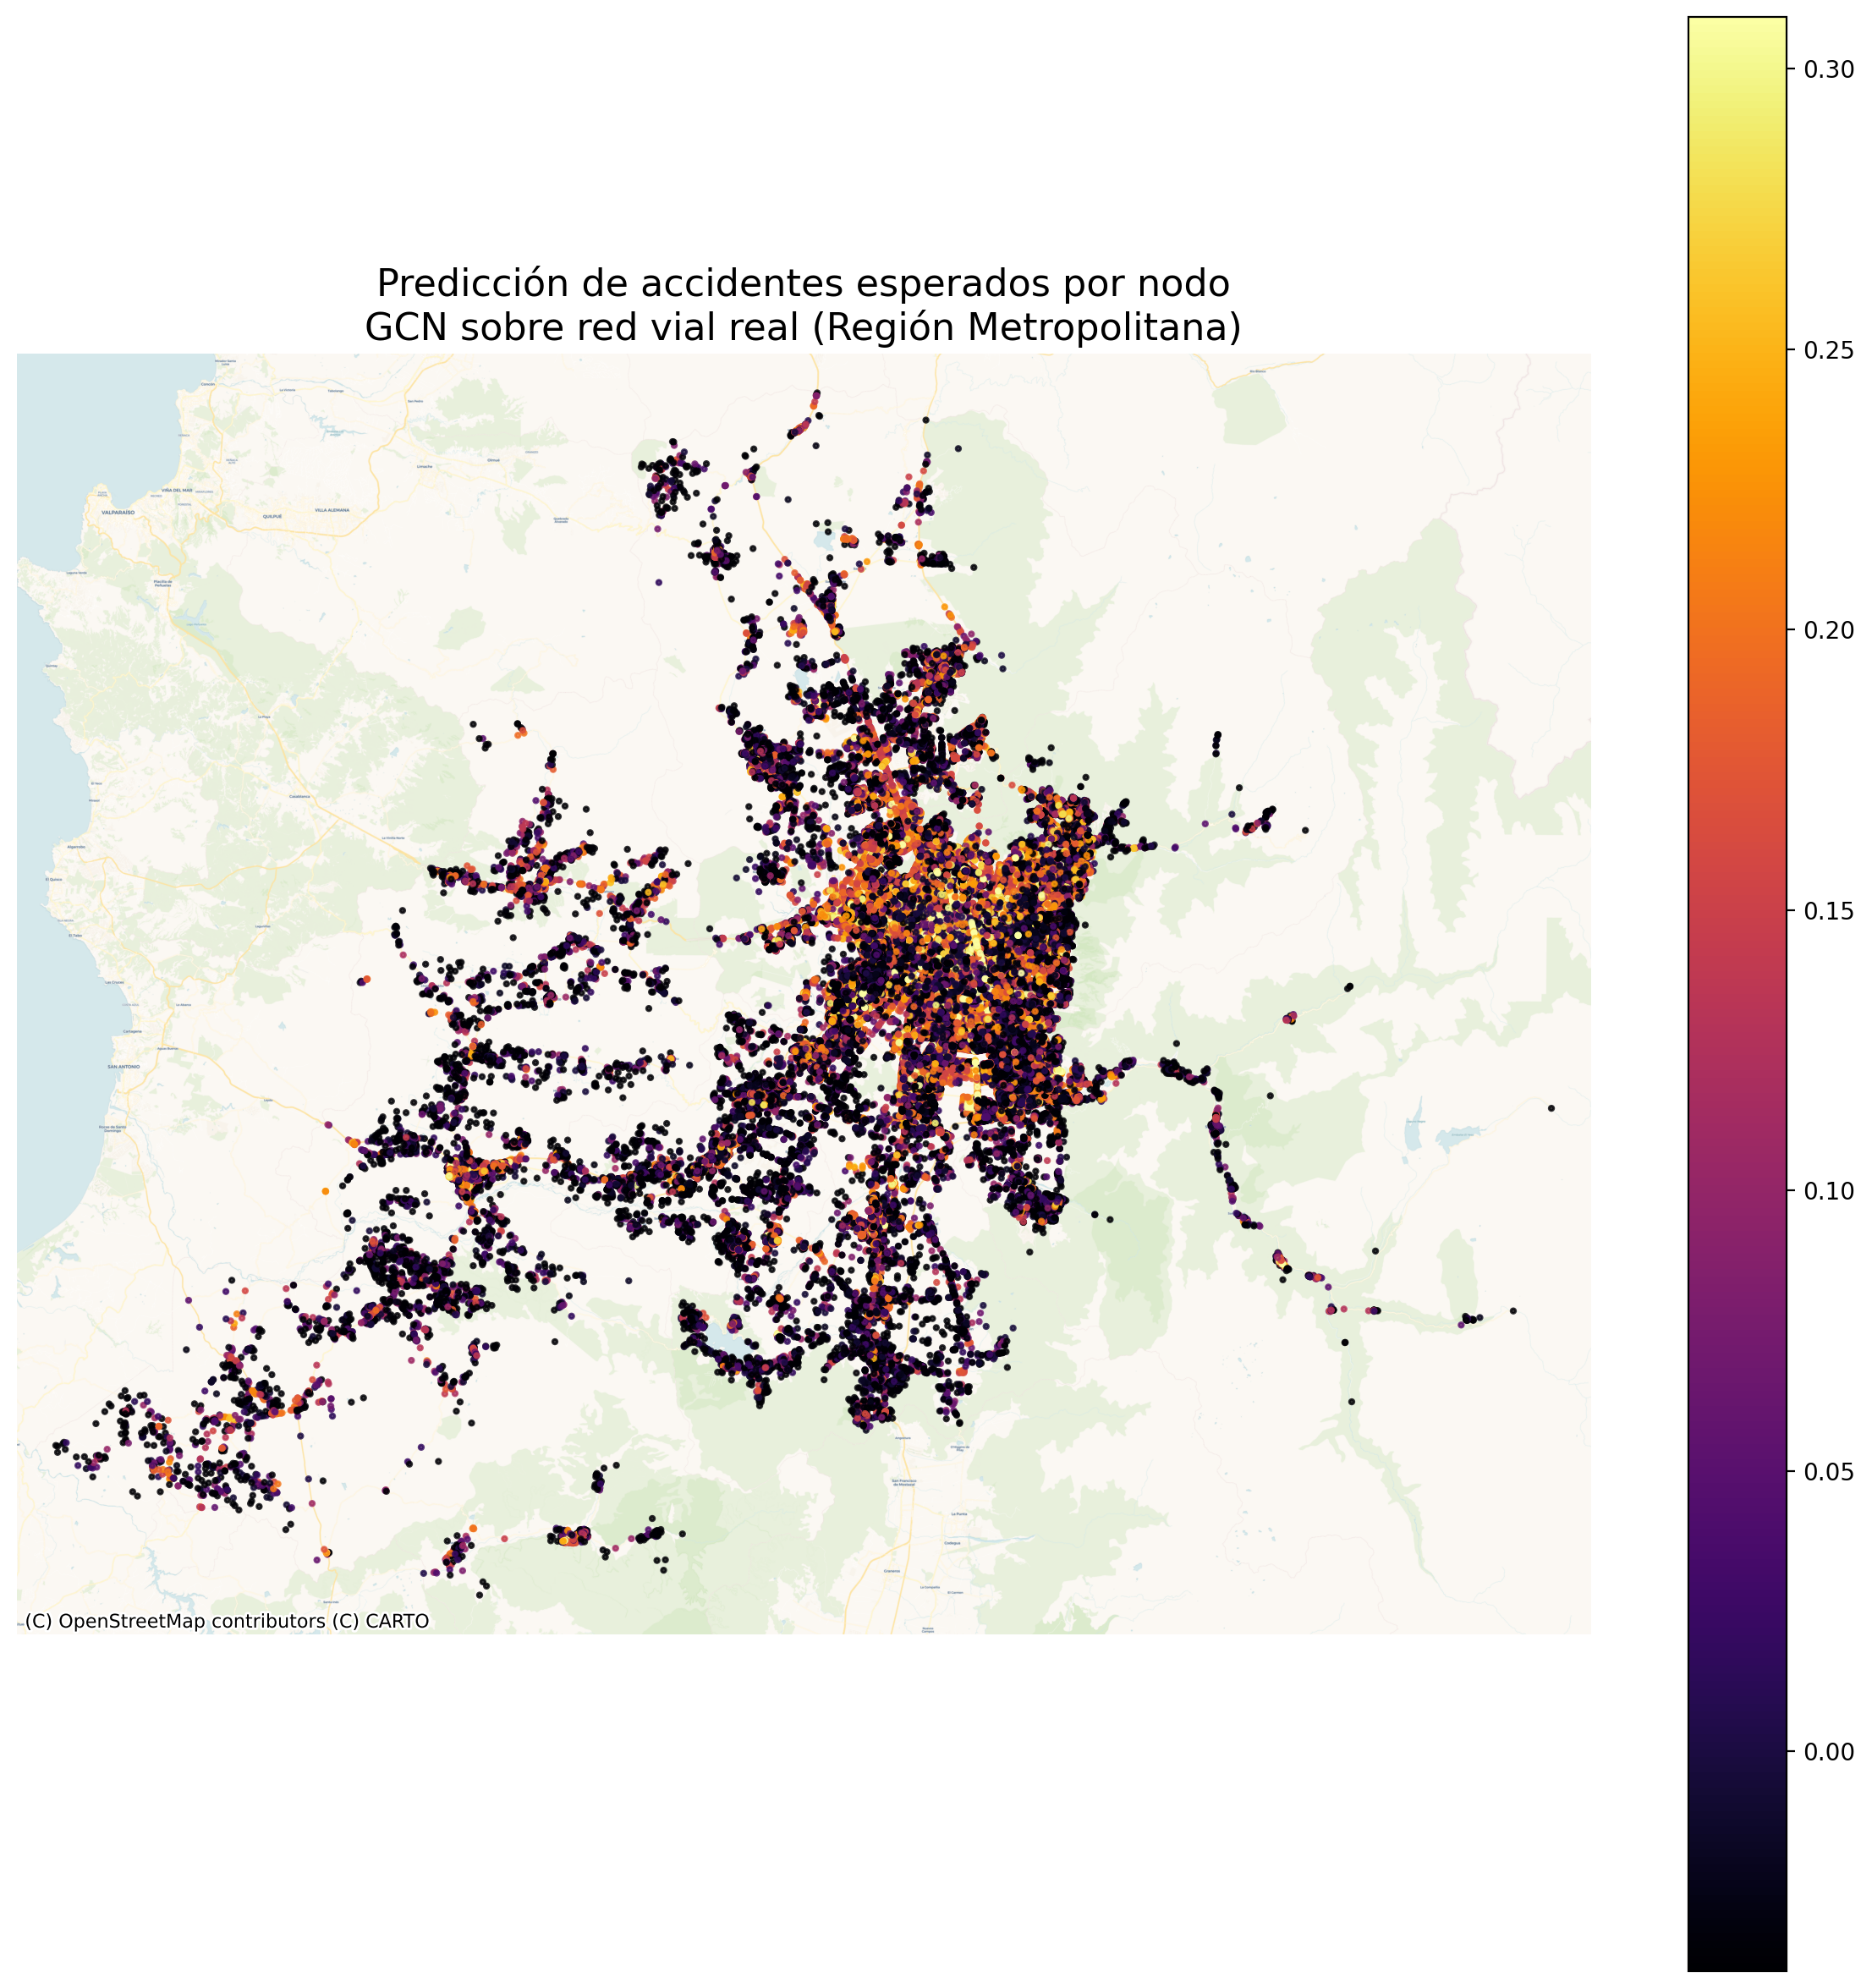

In [16]:
gdf_nodes = gpd.GeoDataFrame(
    df_nodes,
    geometry=gpd.points_from_xy(df_nodes["lon"], df_nodes["lat"]),
    crs="EPSG:4326"
)

gdf_nodes_3857 = gdf_nodes.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 15), dpi=200)
vmin = np.percentile(gdf_nodes_3857["accidentes_pred"], 5)
vmax = np.percentile(gdf_nodes_3857["accidentes_pred"], 95)

gdf_nodes_3857.plot(
    ax=ax,
    column="accidentes_pred",
    cmap="inferno",
    markersize=4,
    alpha=0.8,
    legend=True,
    vmin=vmin,
    vmax=vmax
)

ax.set_xlim(gdf_nodes_3857.total_bounds[0] - 5000,
            gdf_nodes_3857.total_bounds[2] + 5000)
ax.set_ylim(gdf_nodes_3857.total_bounds[1] - 5000,
            gdf_nodes_3857.total_bounds[3] + 5000)

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Voyager,
    zoom=12
)

ax.set_axis_off()
ax.set_title("Predicción de accidentes esperados por nodo\nGCN sobre red vial real (Región Metropolitana)", fontsize=16)
plt.show()
